In [1]:
from os.path import join, isfile
from os import listdir
from PIL import Image
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import csv
import itertools
from scipy.spatial import distance
from sklearn.ensemble import RandomForestClassifier

In [2]:
import classifiers_general

In [3]:
def get_distances(keypoints):
    feats = []
    combs = [comb for comb in itertools.combinations([*range(0, len(keypoints))], 2)]
    for comb in combs:
        a = comb[0]
        b = comb[1]
        
        feats.append(distance.euclidean(keypoints[a], keypoints[b]))
    
    return feats

## From landmark to all distances for syndromic files

## From landmark to all distances for control files

In [4]:
def get_important_features(syn_name, data_dir, data_combination, nr_feats): 

    if data_combination == 9: # facereader landmarks
        method = "facereader-landmarks-distances"
        syn_csv = data_dir+"\\representations\{}-patients-{}.csv".format(syn_name, method)
        ID_csv  = data_dir+"\\representations\ID-controls-{}.csv".format(method)
        data_fr, labels_fr = classifiers_general.read_rep(syn_name, syn_csv, ID_csv, data_dir)

        data, labels  = [], []
        for index, data_i in enumerate(data_fr):
            if not all(v == 0 for v in data_i):
                data.append(data_i) 
                labels.append(labels_fr[index])
                
        forest = RandomForestClassifier(n_estimators=10,random_state=0) # 10 has been found with best aroc scores
        forest.fit(data, labels)
        importances = forest.feature_importances_
        std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
        indices = np.argsort(importances)[::-1]
        important_indices = indices[0:nr_feats] 
        
        print(sum(importances[important_indices]))

        data2 = []
        for row in data:
            data2.append(np.array(row)[important_indices])                                
        data = data2
                
    return np.array(data), np.array(labels),important_indices

def get_keypoints_from_indices(indices):

    combs = [comb for comb in itertools.combinations([*range(0, 510)], 2)]
    keypoints = []
    for index, comb in enumerate(combs):
        if index in indices:
                      
            a = comb[0]
            b = comb[1]
            keypoints.append([a, b])
        
    return keypoints

In [5]:
def fr_plot(patient, GENERAL_DIR):
    face_x = []
    face_y = []
    face_z = []

    
    file = GENERAL_DIR + "\\features_facereader_landmarks_patient_groups.csv"
    print(file)
    with open(file, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if patient in row[0]:
                print(row[0])
                indexed_keypoints = []
                i = 1
                while i < len(row[1:]):
                    indexed_keypoints.append([float(row[i]), float(row[i+1]), float(row[i+2])])
                    face_x.append(float(row[i]))
                    face_y.append(float(row[i+1]))
                    face_z.append(float(row[i+2]))
                    i+=3    
                break
    face_x = np.array(face_x)
    face_y = np.array(face_y)
    face_z = np.array(face_z)
    
    return face_x, face_y, face_z, indexed_keypoints

In [6]:
def get_patient_keypoints(important_keypoints, indexed_keypoints):
    
    keypoints3D = []
        
    for [a, b] in important_keypoints:
        
        keypoints3D.append([indexed_keypoints[a], indexed_keypoints[b]])
        
        
    return keypoints3D

In [11]:
syn_name = 'KDVS'
patient = 'KDVS_1.jpg'
GENERAL_DIR = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien"

x, y, z, indexed_keypoints = fr_plot(patient, GENERAL_DIR)

data_dir = GENERAL_DIR + "\\{}".format(syn_name) 
nr_feats = 10

# _, _, indices = get_important_features(syn_name, data_dir, 9, nr_feats)
# important_keypoints = get_keypoints_from_indices(indices)
# keypoints_3d = get_patient_keypoints(important_keypoints, indexed_keypoints)



H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\features_facereader_landmarks_patient_groups.csv
KDVS_1.jpg


In [14]:
def split_face(x, y, z, x_top, x_bot, y_top, y_bot):
    middle = [288, 298, 299, 262, 263, 304, 302, 168, 297, 294, 295, 296, 292, 302, 282, 284,
                304, 305, 306, 269, 213, 210, 278, 281, 217, 157, 158, 173, 174, 190, 191, 205]
    x_r, y_r, z_r, x_l, y_l, z_l = [], [], [], [], [], []
    right, left = [], []
    
    for i in range(len(x)):
        d1 = (x[i]-x_top[0])*(y_top[1]-y_top[0]) - (y[i]-y_top[0])*(x_top[1]-x_top[0]) 
        d2 = (x[i]-x_bot[0])*(y_bot[1]-y_bot[0]) - (y[i]-y_bot[0])*(x_bot[1]-x_bot[0]) 
        
        if i in middle:
            x_r.append(x[i])
            y_r.append(y[i])
            z_r.append(z[i])
            x_l.append(x[i])
            y_l.append(y[i])
            z_l.append(z[i])
            right.append(i)
            left.append(i)


        else:
            
            if d1 < 0 and d2 < 0 :
                x_r.append(x[i])
                y_r.append(y[i])
                z_r.append(z[i])
                
                right.append(i)
            else:
                x_l.append(x[i])
                y_l.append(y[i])
                z_l.append(z[i])
                
                left.append(i)

    return x_l, y_l, z_l, x_r, y_r, z_r, left, right

In [17]:
%matplotlib notebook
from matplotlib import pyplot
from pylab import figure
from mpl_toolkits.mplot3d import Axes3D

x_top = [x[295], x[288]]
x_bot  = [x[174],  x[295]]
y_top = [y[295], y[288]]
y_bot  = [y[174],  y[295]]

x, y, z, indexed_keypoints = fr_plot(patient, GENERAL_DIR)
x_l, y_l, z_l, x_r, y_r, z_r, left, right = split_face(x, y, z, x_top, x_bot, y_top, y_bot)
print(len(x))

print((left))
print((right))

H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\features_facereader_landmarks_patient_groups.csv
KDVS_1.jpg
510
[0, 1, 2, 3, 4, 5, 6, 7, 8, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,

H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\features_facereader_landmarks_patient_groups.csv
KDVS_1.jpg
32


<IPython.core.display.Javascript object>


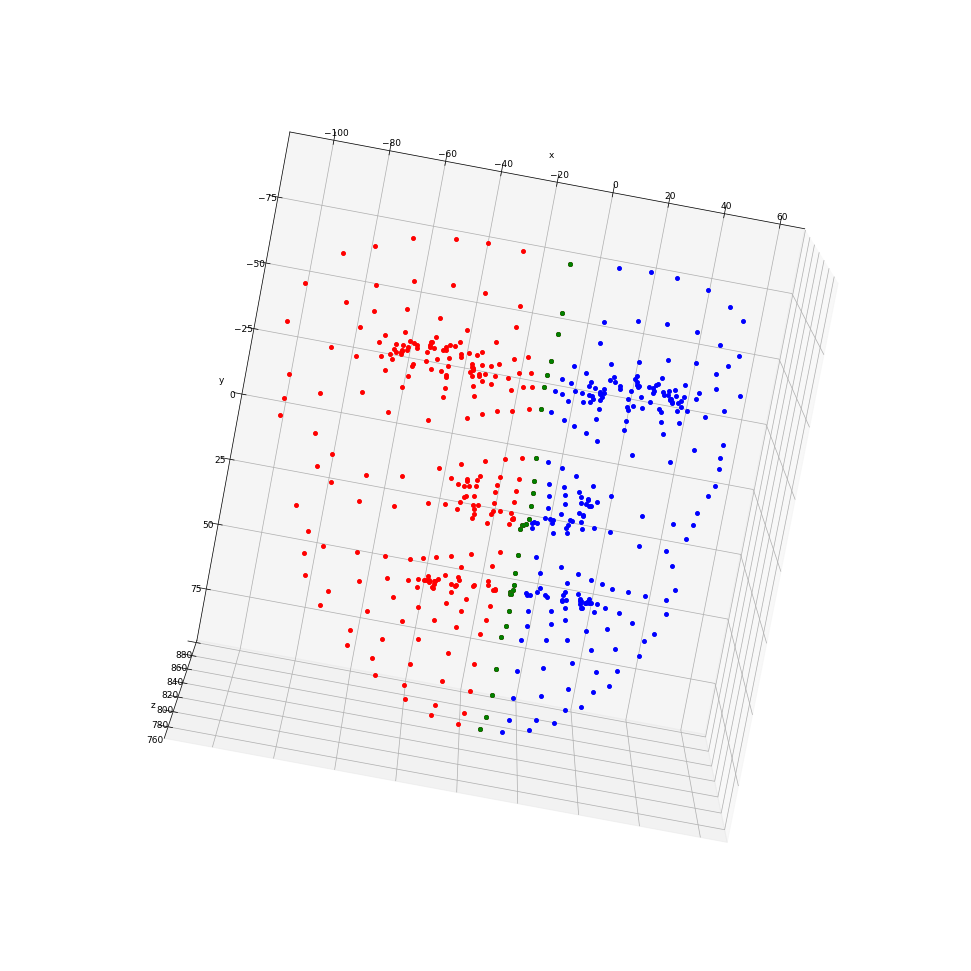

In [13]:
%matplotlib notebook
from matplotlib import pyplot
from pylab import figure
from mpl_toolkits.mplot3d import Axes3D

x_top = [x[295], x[288]]
x_bot  = [x[174],  x[295]]
y_top = [y[295], y[288]]
y_bot  = [y[174],  y[295]]

x, y, z, indexed_keypoints = fr_plot(patient, GENERAL_DIR)
x_l, y_l, z_l, x_r, y_r, z_r, left, right = split_face(x, y, z, x_top, x_bot, y_top, y_bot)

print(len(left))
print(len(right))

# middle = [288, 298, 299, 262, 263, 304, 302, 168, 297, 294, 295, 296, 292, 302, 282, 284,
#             304, 305, 306, 269, 213, 210, 278, 281, 217, 157, 158, 173, 174, 190, 191, 205]
# print(len(middle))
fig = figure(figsize=(15,15))
ax = Axes3D(fig)

for i in range(len(x_r)): 
    ax.scatter(x_r[i], y_r[i], z_r[i], color='b') 
        
for i in range(len(x_l)): 
    ax.scatter(x_l[i], y_l[i], z_l[i], color='r') 

for i in range(len(x)): 
    if i in middle: 
        ax.scatter(x[i], y[i], z[i], color='g') 

# # Calculate the coefficients. This line answers the initial question. 
# coeff_top = np.polyfit(x_top, y_top, 1)
# coeff_bot = np.polyfit(x_bot, y_bot, 1)

# # Let's compute the values of the line...
# poly_top = np.poly1d(coeff_top)
# poly_bot = np.poly1d(coeff_bot)
# x_axis_top = np.linspace(min(x_top), max(x_top),100)
# x_axis_bot = np.linspace(min(x_bot), max(x_bot),100)
# y_axis_top = poly_top(x_axis_top)
# y_axis_bot = poly_bot(x_axis_bot)
# z_axis_top = np.ones(100)* np.mean([z[295], z[288]])
# z_axis_bot = np.ones(100)* np.mean([z[174], z[295]])

# # ...and plot the points and the line
# ax.plot(x_axis_top, y_axis_top, z_axis_top)
# ax.plot(x_axis_bot, y_axis_bot, z_axis_bot)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
pyplot.show()

In [ ]:
# pts3d = np.vstack((x, y, z)).T
# pts2d = pts3d[:, :2]
# tri =   Delaunay(pts2d)
# i, j, k = tri.simplices.T  #tri.simplices (faces) is an array of integers of shape (no_triangles, 3)

# fig = go.Figure(go.Mesh3d(x=x, y=y, z=z,
#                           i=i, j=j, k=k,#intensity=z, 
#                           #colorscale='matter_r', 
#                           flatshading=True))
# fig.show()